### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import tensorflow as tf
from tensorflow import keras
import os

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Load to see what's there in TM.npy file

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


In [4]:
print(Time_matrix)

[[[[ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]
   ...
   [ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]
   [ 0.  0.  0. ...  0.  0.  0.]]

  [[ 2.  3.  3. ...  7.  0.  6.]
   [ 2.  3.  3. ...  7.  0.  6.]
   [ 2.  3.  3. ...  7.  0.  6.]
   ...
   [ 2.  3.  6. ...  7.  4.  2.]
   [ 2.  3.  6. ...  7.  4.  2.]
   [ 2.  3.  6. ...  7.  4.  2.]]

  [[ 2.  6.  5. ...  3.  7.  7.]
   [ 2.  6.  5. ...  3.  7.  7.]
   [ 2.  6.  5. ...  3.  7.  7.]
   ...
   [ 6.  2.  8. ...  4.  5.  5.]
   [ 6.  2.  8. ...  4.  5.  5.]
   [ 6.  2.  8. ...  4.  5.  5.]]

  [[10.  6.  8. ...  7.  4.  6.]
   [10.  6.  8. ...  7.  4.  6.]
   [10.  6.  8. ...  7.  4.  6.]
   ...
   [ 0.  1.  2. ...  1.  3.  3.]
   [ 0.  1.  2. ...  1.  3.  3.]
   [ 0.  1.  2. ...  1.  3.  3.]]

  [[ 1.  1.  1. ...  1.  1.  1.]
   [ 1.  1.  1. ...  1.  1.  1.]
   [ 1.  1.  1. ...  1.  1.  1.]
   ...
   [ 6.  4.  7. ...  3.  1.  8.]
   [ 6.  4.  7. ...  3.  1.  8.]


This contains some details about taxi rides, max being 11 between 2 points and minimum being 0 (probably cancelled ride)

#### Tracking the state-action pairs for checking convergence


In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [41]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01       
        self.epsilon_max = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        self.epsilon = 1
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)
            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action, reward, next_state,done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                # Write your code from here
                # 1. Predict the target from earlier model
                # 2. Get the target for the Q-network  
                # 3. Update your 'update_output' and 'update_input' batch
                # 4. Fit your model and track the loss values                
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)   
                
            # predict the target q-values    
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
    def save(self, name):
        self.model.save(name)

    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

In [73]:
Episodes = 20000 #is the ideal
episode_time = 24*30 #30 days before which car has to be recharged

m = 5  # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### DQN block

In [74]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    #Call the DQN agent
    
    done = False #terminal_state = False
    score = 0
    track_reward = False    

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init

    total_time = 0  # Total time driver rode in this episode
        
    while not done: #terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        
        # Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)
        # Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # Total time driver rode in this episode
        total_time += step_time
        
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # Train the model by calling function agent.train_model
            agent.train_model()
            # Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    #agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
        # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    # every 10 episodes:
    #if ((episode + 1) % 10 == 0):
        #print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
         #                                                                score,
         #                                                                len(agent.memory),
         #                                                                agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)
    
    if(episode % 500 == 0):
        print("episode",episode)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.h5") #arpitha model_weights.pkl
    
elapsed_time = time.time() - start_time
print("Elapsed time: ", elapsed_time)

episode 0
Saving Model 0
episode 500
episode 1000
Saving Model 1000
episode 1500
episode 2000
Saving Model 2000
episode 2500
episode 3000
Saving Model 3000
episode 3500
episode 4000
Saving Model 4000
episode 4500
episode 5000
Saving Model 5000
episode 5500
episode 6000
Saving Model 6000
episode 6500
episode 7000
Saving Model 7000
episode 7500
episode 8000
Saving Model 8000
episode 8500
episode 9000
Saving Model 9000
episode 9500
episode 10000
Saving Model 10000
episode 10500
episode 11000
Saving Model 11000
episode 11500
episode 12000
Saving Model 12000
episode 12500
episode 13000
Saving Model 13000
episode 13500
episode 14000
Saving Model 14000
episode 14500
episode 15000
Saving Model 15000
episode 15500
episode 16000
Saving Model 16000
episode 16500
episode 17000
Saving Model 17000
episode 17500
episode 18000
Saving Model 18000
episode 18500
episode 19000
Saving Model 19000
episode 19500
Elapsed time:  11369.160361528397



total_time :

In [76]:
agent.save(name="model_weights.h5")

### Tracking Convergence

In [77]:
agent.states_tracked

[8168.448,
 1650.8337,
 435.2131,
 280.22406,
 245.52039,
 265.38342,
 270.96094,
 206.69836,
 259.15784,
 279.8903,
 252.02289,
 291.38596,
 360.8008,
 406.49094,
 396.5074,
 424.13684,
 575.96655,
 581.1103,
 524.7031,
 629.22156,
 415.62866,
 414.1154,
 442.5042,
 465.07407,
 482.45157,
 502.03232,
 539.2997,
 687.2857,
 530.71106,
 486.8134,
 593.0287,
 542.95135,
 574.06494,
 508.58798,
 531.30756,
 543.7666,
 545.50793,
 538.3363,
 502.37762,
 525.4958,
 547.84985,
 546.6164,
 598.4165,
 508.2043,
 551.3002,
 571.2093,
 479.02832,
 557.2129,
 571.1065,
 552.271,
 561.09576,
 527.1828,
 530.06213,
 539.1485,
 519.5134,
 547.7547,
 490.77896,
 526.3917,
 527.55444,
 549.9631,
 589.0506,
 582.63086,
 532.5707,
 588.22156,
 571.17255,
 559.8828,
 524.1889,
 571.1594,
 567.3383,
 590.0181,
 579.5469,
 565.2363,
 577.67084,
 538.5646,
 588.7095,
 556.5526,
 529.3139,
 595.3729,
 541.0047,
 607.74695,
 572.07574,
 543.33154,
 534.52313,
 588.8363,
 530.4532,
 588.1867,
 569.79004,
 594.

In [78]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

In [79]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")


In [80]:
# save rewards_per_episode
save_obj(rewards_per_episode, "saved_pickle_files/rewards_per_episode")

In [81]:
# plot results
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

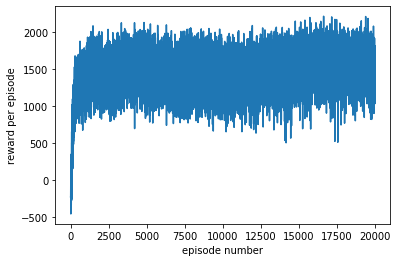

In [82]:
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.savefig('rewards.png')

In [83]:
print(rewards_per_episode)

[-224.0, -234.0, -130.0, -201.0, -188.0, -234.0, -172.0, -87.0, -221.0, -135.0, 63.0, -328.0, -454.0, -80.0, -54.0, 104.0, -211.0, -97.0, -138.0, -187.0, -36.0, -396.0, -189.0, -139.0, -201.0, -141.0, 91.0, -255.0, -4.0, 37.0, -278.0, 353.0, -56.0, -107.0, 105.0, -170.0, -2.0, -27.0, 276.0, -331.0, -72.0, -295.0, 199.0, -52.0, -117.0, 45.0, -53.0, 24.0, -210.0, 183.0, 39.0, -21.0, 212.0, 262.0, 110.0, -93.0, -273.0, 42.0, 123.0, -93.0, 172.0, -8.0, 83.0, 52.0, -143.0, 377.0, 198.0, 658.0, 73.0, 509.0, -125.0, 288.0, 199.0, -68.0, 56.0, 375.0, 172.0, -252.0, 191.0, 387.0, 235.0, 262.0, 112.0, 410.0, 401.0, 340.0, 324.0, 284.0, -85.0, 185.0, 546.0, 522.0, 451.0, 812.0, 302.0, 654.0, 290.0, 541.0, 375.0, 237.0, 466.0, 264.0, 361.0, 603.0, 136.0, 772.0, 1024.0, 180.0, 356.0, 285.0, 866.0, 491.0, 437.0, 671.0, 450.0, 856.0, 333.0, 279.0, 320.0, 232.0, 439.0, 567.0, 1101.0, 591.0, 543.0, 747.0, 808.0, 626.0, 594.0, 770.0, 872.0, 893.0, 736.0, 231.0, 613.0, 735.0, 540.0, 293.0, 638.0, 819.0, 

In [84]:
print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-1000:]))) 

Average reward of last 100 episodes is 1564.331


Observation : 
- The rewards have increased in the start until around 1500 and then it has kind of stabilized to tell that the model has learnt enough with the hyper parameters set. 
- Zip file has rewards images for 5000, 20000 episodes and there isnt much of difference in the learning rate. 
- We have tested with other epsilon-decay function but model was not learning enough. So had to use the above listed decay function.
- Model took about 3-4 hours to execute.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [85]:
    time = np.arange(0,10000)
    epsilon = []
    for i in range(0,10000):
        epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

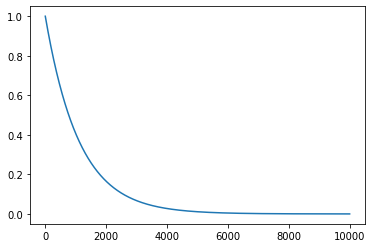

In [86]:
plt.plot(time, epsilon)
plt.show()